In [79]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from os.path import join
import ipywidgets as widgets
from IPython.display import display
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import pickle
from torchsampler import ImbalancedDatasetSampler
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report

In [2]:
#import torch
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable

**Observaciones**

- La capa de entrada tiene dimension 5 (5 neuronas) porque son 5 características (mjd, mag, err, phs, real), aunque la ultima columna 'real' es una máscara, por lo que puede no ser considerada en la entrada.
- La capa de salida tiene dimension 5, porque son 5 tipos de estrellas varibles a clasificar.
- probaremos con 2 capas internas (hidden) que serán Linear
- probaré con la función de activación ReLU internamente.
- la fucion de costo en la salida será CrossEntropy (que usa SoftMax)
- el optimizador será .........
- para los pesos (weights) creo que no es tan necesario darles relevancia, ya que gracias al ImbalancedDatasetSampler se tiene un muestreo equitativo entre las clases.
- 

**Definiciones**

In [ ]:
# original

class LightCurveRRL_Dataset(Dataset):
    def __init__(self, df_metadata, folder_name, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["OGLE_period"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        column_names_fill = ["mjd", "mag", "err", "phase", "real"]
        self.folder = folder_name
        #self.classes = ["T2C", "ECL"]
        df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
                
        for i in range(len(df_metadata)):
            rrl_data = pd.read_csv(join(data_path, self.folder, self.name[i]+'.dat'), 
                                  header=None, delim_whitespace=True, comment='#', names=column_names_lc)
            rrl_data.sort_values(by="mjd", inplace=True)
            rrl_data["phase"] = np.mod(rrl_data["mjd"], self.period[i])/self.period[i]
            #normalize
            rrl_data["mjd"] = rrl_data["mjd"]-rrl_data["mjd"].min()
            rrl_data["mag"] = (rrl_data["mag"]-rrl_data["mag"].mean())/rrl_data["mag"].std()
            rrl_data["err"] = rrl_data["err"]/rrl_data["mag"].std()
            # ajustar todas a largo 335, rellenando con 0s las que sean mas pequeñas,
            # asignando un label '1' si es dato real y '0' si es dato rellenado.
            if len(rrl_data) == 335:
                rrl_data['real'] = 1
            else:
                while len(rrl_data) < 335:
                    #RELLENAR con 0s;
                    rrl_data = rrl_data.append(df_zeros, ignore_index=True,sort=False)
            rrl_data = rrl_data.fillna(1)
            self.data.append(torch.from_numpy(rrl_data.values.astype('float32')))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def plot(self, idx, ax):
        assert len(ax)==2, "Needs two subaxis"
        ax[0].cla()  
        ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[0].invert_yaxis()
        ax[1].cla()
        ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[1].invert_yaxis()
        ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)

In [3]:
# Magnitude Interpolation
#import torch
from torch.utils.data import Dataset

class LightCurveRRL_Dataset(Dataset):
    def __init__(self, df_metadata, folder_name, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["OGLE_period"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        #column_names_fill = ["mjd", "mag", "err", "phase", "real"]
        self.folder = folder_name
        self.mag_inter = torch.empty(100)
        self.label = torch.empty(1)
        #self.classes = ["T2C", "ECL"]
        #df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
                
        for i in range(len(df_metadata)):
            rrl_data = pd.read_csv(join(data_path, self.folder, self.name[i]+'.dat'), 
                                  header=None, delim_whitespace=True, comment='#', names=column_names_lc)
            rrl_data["phase"] = np.mod(rrl_data["mjd"], self.period[i])/self.period[i]
            #normalize
            mag_std = rrl_data["mag"].std()
            rrl_data["mjd"] = rrl_data["mjd"]-rrl_data["mjd"].min()
            rrl_data["mag"] = (rrl_data["mag"]-rrl_data["mag"].mean())/mag_std
            rrl_data["err"] = rrl_data["err"]/mag_std
            # Interpolacion
            # ventaneo Gaussiano
            window = lambda phi_point : np.exp(-0.5*(phi_point-rrl_data["phase"])**2/0.03**2)
            # espaciado regular de 100 pts entre 0 y 1
            phi_interp = np.linspace(0, 1, num=100)
            # cálculo de la interpolacion (prediccion) de la magnitud "basado en la cercania entre los puntos"
            rrl_data["mag"] = np.array([np.sum(window(phi_val)*rrl_data["mag"])/np.sum(window(phi_val)) for phi_val in phi_interp])
            rrl_data.sort_values(by="phase", inplace=True)
            # orden cols: ['mjd','mag','err','phase']
            self.data.append(torch.from_numpy(rrl_data.values.astype('float32')))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    #def plot(self, idx, ax):
    #    assert len(ax)==2, "Needs two subaxis"
    #    ax[0].cla()  
    #    ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
    #    ax[0].invert_yaxis()
    #    ax[1].cla()
    #    ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
    #    ax[1].invert_yaxis()
    #    ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)


In [4]:
with open('ecl_c.pkl', 'rb') as handle:
    vvv_ecl_c = pickle.load(handle)
#label 0

In [5]:
with open('ecl_nc.pkl', 'rb') as handle:
    vvv_ecl_nc = pickle.load(handle)
#label 1

In [6]:
with open('ell.pkl', 'rb') as handle:
    vvv_ell = pickle.load(handle)
#label 2

In [7]:
with open('rrab.pkl', 'rb') as handle:
    vvv_rrab = pickle.load(handle)
#label 3

In [8]:
with open('rrc.pkl', 'rb') as handle:
    vvv_rrc = pickle.load(handle)
#label 4

In [ ]:
vvv_rrc[400]['data'][:2][:]

In [9]:
VVV_b = [vvv_ecl_c,vvv_ecl_nc,vvv_ell,vvv_rrab,vvv_rrc]
VVV_len = [len(i) for i in VVV_b]
class_names = ['ECL_C','ECL_NC','ELL','RRAB','RRC']

In [10]:
def count_classes(datos):
    classes=[[0,0],[1,0],[2,0],[3,0],[4,0]]
    for data in datos:
        label = int(data['label'][0].item())
        #print(label)
        if label == 0:
            classes[0][1]+=1
        elif label == 1:
            classes[1][1]+=1
        elif label == 2:
            classes[2][1]+=1
        elif label == 3:
            classes[3][1]+=1
        elif label == 4:
            classes[4][1]+=1
    return classes
            
    

In [11]:
#dataset
VVV = torch.utils.data.ConcatDataset([vvv_ecl_c, vvv_ecl_nc, vvv_ell,vvv_rrab, vvv_rrc])
#VVV = torch.utils.data.ConcatDataset([vvv_ecl_c, vvv_rrab])

In [353]:
VVV_b[0].__len__()

17882

In [349]:
VVV_len

[17882, 26880, 789, 21123, 429]

**Transformar y filtrar datos**
- Ordenar por Phase: idx = argsort('phase')
- Crear mag_sort segun idx calculado: mag_sort[idx]
- Ordenar máscara acorde a distribucion generada anteriormente: mask_sort[idx]

> lo anterior hará que el tiempo ya no sea relevante y le dará información mas "directa" a la red del comportamiento de la estrella a estudiar.
Además pasaremos de tener 5 columnas (canales para la red) a trabajar con sólo 3: Phase, Mag y Mask.
Posteriormente, segun como sea el entrenamiento/aprendizaje del modelo, se incluirá la columna de Error.

In [ ]:
class LightCurveDataset_interpol(Dataset):
    def __init__(self,old_dataset):
        self.new_data = list()
        self.phase = torch.empty(335)
        self.mag = torch.empty(335)
        #self.mask = torch.empty(335)
        self.label = torch.empty(1)
        phi_interp = np.linspace(0, 1, num=100)
        for i in old_dataset:
            #phase_data = i['data'][:,3]
            self.label = i['label']
            #print(self.label)
            #idx = phase_data.argsort()
            self.phase = i['data'][0]
            self.mag = i['data'][1]
            #print(self.phase)
            #self.mask = i['data'][:,4][idx]
            #datos = torch.stack((self.phase,self.mag,self.mask),0)
            # Interpolacion
            # ventaneo Gaussiano
            window = lambda phi_point : np.exp(-0.5*(phi_point-self.phase)**2/0.03**2)
            # espaciado regular de 100 pts entre 0 y 1
            # cálculo de la interpolacion (prediccion) de la magnitud "basado en la cercania entre los puntos"
            mag_interp = np.array([np.sum(window(phi_val)*self.mag)/np.sum(window(phi_val)) for phi_val in phi_interp])
            datos=torch.from_numpy(mag_interp)
            self.new_data.append({'data':datos,'label':self.label})
    
    def __getitem__(self,i):
        sample = {'data': self.new_data[i]['data'], 'label': self.new_data[i]['label']}
        return sample
    
    def __len__(self):
        return len(self.new_data)
            

In [ ]:
best_interpoladas = LightCurveDataset_interpol(best_ecl_rrab)
print(best_interpoladas)
        

In [ ]:
VVV_pha = LightCurveDataset_phase(VVV)
# VVV_pha[n° curva de luz][data o label][pha, mag, mask]

In [ ]:
VVV_pha[0]['data'][0]

In [ ]:
len(VVV),len(VVV_pha)

Observamos la desigualdad de clases

In [ ]:
for i,a in enumerate(VVV_b):
    print("% de",class_names[i],"en VVV:",len(a)/len(VVV)*100)
    print("peso inverso: ",1-len(a)/len(VVV))

<IPython.core.display.Javascript object>


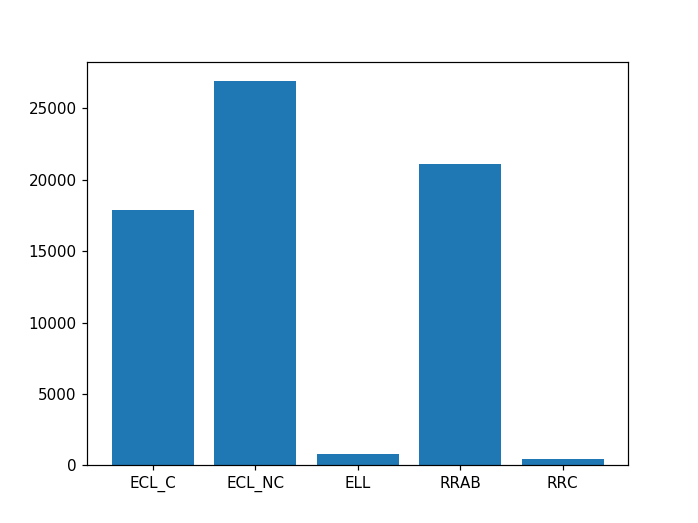

<BarContainer object of 5 artists>

In [12]:
plt.figure()
plt.bar(range(5),VVV_len, tick_label=class_names)

In [ ]:
minimo = min([sum(i['data'][:,4]==1) for i in VVV])
print(minimo)
# 51

In [74]:
VVV[420]['data']

tensor([ 0.9866,  1.0504,  1.1215,  1.1953,  1.2620,  1.3096,  1.3313,  1.3294,
         1.3122,  1.2873,  1.2574,  1.2196,  1.1642,  1.0743,  0.9289,  0.7193,
         0.4730,  0.2462,  0.0754, -0.0414, -0.1232, -0.1868, -0.2425, -0.2962,
        -0.3523, -0.4164, -0.4957, -0.5963, -0.7183, -0.8517, -0.9769, -1.0696,
        -1.1073, -1.0779, -0.9911, -0.8782, -0.7719, -0.6879, -0.6224, -0.5606,
        -0.4828, -0.3688, -0.2113, -0.0317,  0.1301,  0.2520,  0.3417,  0.4197,
         0.5045,  0.6062,  0.7248,  0.8518,  0.9761,  1.0895,  1.1879,  1.2693,
         1.3301,  1.3634,  1.3584,  1.3066,  1.2099,  1.0860,  0.9579,  0.8385,
         0.7255,  0.6058,  0.4612,  0.2740,  0.0365, -0.2344, -0.4973, -0.7139,
        -0.8733, -0.9867, -1.0702, -1.1354, -1.1872, -1.2260, -1.2501, -1.2584,
        -1.2510, -1.2277, -1.1880, -1.1329, -1.0682, -1.0030, -0.9446, -0.8933,
        -0.8429, -0.7823, -0.6992, -0.5839, -0.4371, -0.2750, -0.1236, -0.0032,
         0.0801,  0.1313,  0.1596,  0.17

In [70]:
pts200 = list()
for i in VVV:
    if sum(i['data'])>=200:
        pts200.append(i)
print(len(pts200))

0


In [ ]:
best_0=list()
for i in pts200:
    if i['label'].item()==0:
        best_0.append(i)

print(len(best_0))

best_1=list()
for i in pts200:
    if i['label'].item()==1:
        best_1.append(i)

print(len(best_1))

best_2=list()
for i in pts200:
    if i['label'].item()==2:
        best_2.append(i)

print(len(best_2))

best_3=list()
for i in pts200:
    if i['label'].item()==3:
        best_3.append(i)

print(len(best_3))

best_4=list()
for i in pts200:
    if i['label'].item()==4:
        best_4.append(i)

print(len(best_4))

In [ ]:
len(best_of_best)

In [ ]:
classes = ('ECL_Contact', 'ECL_No-Contact', 'Ellipsoid','RRL_AB', 'RRL_C')
#besties = list()
best_of_best=list()

In [ ]:
best2ofthem=list()

In [ ]:
k = np.random.randint(len(best_of_best))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
def plotea(datos, k, ax,classes):
    #assert len(ax)==1, "Needs one subaxis"
    n = int(sum(datos[k]['data'][2] == 1))
    l = datos[k]['label'][0].item()
    ax.cla()
    ax.plot(datos[k]['data'][0], datos[k]['data'][1],'b.')
    ax.invert_yaxis()
    ax.set_title("estrella tipo %s, pts=%d, k=%d" %(classes[l],n,k))

plotea(best_of_best,k, ax,classes)
#plotea(VVV_pha,k, ax,classes)
b1 = widgets.Button(description="Otra")
b2 = widgets.Button(description="Save this")
display(widgets.HBox([b1,b2]))

def on_button_clicked(b):
    global k,best_0,best_1,best_2,best_3,best_4,best_of_best
    if b.description == "Save this":
        print("not implemented.")
        #best_of_best.append(best_4[k])
        #print("guardada, k=",k,count_classes(best_of_best))
    else:
        k = np.random.randint(len(best_of_best))
        #print(k)
        plotea(best_of_best,k, ax,classes)
        #plotea(VVV_pha,k, ax,classes)

    
b1.on_click(on_button_clicked)
b2.on_click(on_button_clicked)

#classes = ('ECL_Contact', 'ECL_No-Contact', 'Ellipsoid','RRL_AB', 'RRL_C')

In [ ]:
best_rrab,best_ecl_c = list(),list()
for i in best_of_best:
    if i['label']==0:
        best_ecl_c.append(i)
    elif i['label']==3:
        best_rrab.append(i)
print(len(best_rrab),len(best_ecl_c))
        

In [ ]:
best_ecl_rrab = np.concatenate((best_ecl_c,best_rrab),axis=0)
best_ecl_rrab[10]['label']

In [ ]:
# INTERPOLAR
def interpolar_LC(phi,mag):
    # ventaneo Gaussiano
    window = lambda phi_point : np.exp(-0.5*(phi_point-phi)**2/0.03**2)

    # espaciado regular de 100 pts entre 0 y 1
    phi_interp = np.linspace(0, 1, num=100)

    # cálculo de la interpolacion (prediccion) de la magnitud "basado en la cercania entre los puntos"
    mag_interp = np.array([np.sum(window(phi_val)*mag)/np.sum(window(phi_val)) for phi_val in phi_interp])
    
    # PLOT
    #fig,ax=plt.subplots()
    #ax.invert_yaxis()
    #ax.scatter(phi, mag)
    #ax.plot(phi_interp, mag_interp, lw=2, c='r')
    #plt.show()
    #print("plot")
    return mag_interp

In [ ]:
with open('best50_10each_notInterpol.pkl', 'wb') as handle:
    pickle.dump(best_of_best, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('ok')

In [ ]:
with open('best_10ecl_10rrab_10each_notInterpol.pkl', 'wb') as handle:
    pickle.dump(best_ecl_rrab, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('ok')

In [ ]:
display(count_classes(best_of_best))

- para el TEST_set:
    - sacar las 200 primeras LC de cada clase (0,1,2,3,4)
    - 200 0
    - 200 1
    - 200 3
    - 200 2
    - 200 4
- para el TRAIN_set:
    - todas las restantes (66103(?)

In [13]:
test_set_indices = list()

In [14]:
c1,c2,c3,c4,c5= 0,0,0,0,0
for i in range(len(VVV)):
    if c1<250:
        if VVV[i].__getitem__('label').item()== 0:
            test_set_indices.append(i)
            c1+=1
    elif c2<250:
        if VVV[i].__getitem__('label').item()== 1:
            test_set_indices.append(i)
            c2+=1
    elif c3<250:
        if VVV[i].__getitem__('label').item()== 2:
            test_set_indices.append(i)
            c3+=1
    elif c4<250:
        if VVV[i].__getitem__('label').item()== 3:
            test_set_indices.append(i)
            c4+=1
    elif c5<250:
        if VVV[i].__getitem__('label').item()== 4:
            test_set_indices.append(i)
            c5+=1
display(len(test_set_indices))    

1000

In [ ]:
c1,c2,c3,c4,c5= 0,0,0,0,0
for i in range(len(VVV_pha)):
    if c1<200:
        if VVV_pha[i].__getitem__('label').item()== 0:
            test_set_indices.append(i)
            c1+=1
    elif c2<200:
        if VVV_pha[i].__getitem__('label').item()== 1:
            test_set_indices.append(i)
            c2+=1
    elif c3<200:
        if VVV_pha[i].__getitem__('label').item()== 2:
            test_set_indices.append(i)
            c3+=1
    elif c4<200:
        if VVV_pha[i].__getitem__('label').item()== 3:
            test_set_indices.append(i)
            c4+=1
    elif c5<200:
        if VVV_pha[i].__getitem__('label').item()== 4:
            test_set_indices.append(i)
            c5+=1

display(len(test_set_indices))    

In [121]:
targets = [i['label'].item() for i in VVV]
targets.__len__()

67103

In [310]:
#from sklearn.model_selection import train_test_split


train_idx, valid_idx= train_test_split(
                                    np.arange(len(targets)),
                                    test_size=0.25,
                                    shuffle=True,
                                    stratify=targets)
train_idx, valid_idx = list(train_idx), list(valid_idx)
display(len(train_idx), len(valid_idx))

50327

16776

In [15]:
test_set_indices = set(test_set_indices)
whole_set_indices = set(range(len(VVV)))

train_set_indices = whole_set_indices - test_set_indices
train_set = list(train_set_indices)
test_set = list(test_set_indices)

In [75]:
# splitear Train y Test sets random ~75/25 = 50328/16775, ~80/20 = 53683/13420
whole_indices = np.arange(VVV.__len__())
np.random.shuffle(whole_indices)
random_test_set = set(whole_indices[:13420])
#display(random_test_set)
whole_indices = set(whole_indices)
train_set_randind = whole_indices - random_test_set
train_set = list(train_set_randind)
test_set = list(random_test_set)
display(train_set.__len__(),test_set.__len__())

53683

13420

In [311]:
# probar SIN ImbalancedDatasetSampler

train_loader = DataLoader(VVV,
    sampler=SubsetRandomSampler(train_idx),
    batch_size=32, shuffle=False)

test_loader = DataLoader(VVV,
    sampler=SubsetRandomSampler(valid_idx),
    batch_size=128, shuffle=False)

In [ ]:
print(test_loader.__len__())

In [336]:
# CON ImbalancedDatasetSampler
train_loader = DataLoader(VVV,
                          sampler=ImbalancedDatasetSampler(VVV,
                                                           indices=train_idx,
                                                           callback_get_label= lambda dataset, idx:dataset.__getitem__(idx)['label'].item()),
                          batch_size=32, shuffle=False)

test_loader= DataLoader(VVV,
                        sampler=SubsetRandomSampler(valid_idx),
                        batch_size=128, shuffle=False)


**Definir MODELO**

In [ ]:
# implementacion adaptada a 1D de https://github.com/naoto0804/pytorch-inpainting-with-partial-conv

class PartialConv(nn.Module):
    def __init__(self, in_channels_C,in_channels_M, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.input_conv = nn.Conv1d(in_channels_C, out_channels, kernel_size,
                                    stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv1d(in_channels_M, out_channels, kernel_size,
                                   stride, padding, dilation, groups, False)
        # self.input_conv.apply(weights_init('kaiming'))

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self,input, mask):
        # http://masc.cs.gmu.edu/wiki/partialconv
        # C(X) = W^T * X + b, C(0) = b, D(M) = 1 * M + 0 = sum(M)
        # W^T* (M .* X) / sum(M) + b = [C(M .* X) – C(0)] / D(M) + C(0)
        #print(input.shape, mask.shape)
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        no_update_holes = output_mask == 0
        mask_sum = output_mask.masked_fill_(no_update_holes, 1.0)

        output_pre = (output - output_bias) / mask_sum + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)

        new_mask = torch.ones_like(output)
        new_mask = new_mask.masked_fill_(no_update_holes, 0.0)

        return output, new_mask




In [312]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels_C=1,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=5): 
        super(MLP, self).__init__()
        #part=PartialConv()
        # Minimo entran 51 elementos y máximo entran 335.
        self.conv1 = torch.nn.Conv1d(in_channels_C, c4, kernel_size,stride=2, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #self.pconv1 = PartialConv(in_channels_C,in_channels_M, c1, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.conv2 = torch.nn.Conv1d(c1, c1, kernel_size, stride=2, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #self.pconv2 = PartialConv(c1, c1, c1, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.conv3 = torch.nn.Conv1d(c4, c4, kernel_size, stride=2, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #self.pconv3 = PartialConv(c1, c1, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.conv4 = torch.nn.Conv1d(c2, c2, kernel_size, stride=2, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #self.pconv4 = PartialConv(c2, c2, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.conv5 = torch.nn.Conv1d(c4, c4, kernel_size, stride=2, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #self.pconv5 = PartialConv(c2, c2, c3, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        # pooling MAX
        # tamaño stride = tamaño kernel. para que reduzca elementos
        self.pool1 = torch.nn.MaxPool1d(kernel_size, stride=kernel_size, padding=0,
                                        dilation=1, return_indices=False, ceil_mode=False)
        # pooling AVG
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        #self.gap = torch.nn.AdaptiveMaxPool1d(1, return_indices=False)
        self.gap = torch.nn.AdaptiveMaxPool1d(10)
        # RESHAPE segun dimensiones entregadas por la ultima capa
        # Creamos X capas completamente conectadas
        self.hidden1 = torch.nn.Linear(c4*10, hid3_dim, bias=True)
        #self.hidden2 = torch.nn.Linear(hid_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid3_dim, output_dim, bias=False)
        # Función de activación ReLU
        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    # Forward: Conecta la entrada con la salida
    def forward(self, x, t=0):
        
        if t==1:
            x = x.transpose(0,1)
            #mask = mask.transpose(0,1)
        elif t==2:
            x = x.transpose(1,2)
            #mask = mask.transpose(1,2)
    
        # Pasamos x por la primera las capas Conv, despues de c/u, función de activ. y pooling, la ultima con avgpool
        # Asegurar mascara antes de PartialConv
        #x, mask = self.pconv1(x, mask)
        #print("after conv1",x.shape, mask.shape)
        #x = (self.activation(x))
        #mask = self.pool1(mask)
        #print("after pool",x.shape, mask.shape)
        x = self.pool1(self.activation(self.conv1(x)))
        #x, mask = PartialConv.forward_partial(self.pconv2,x, mask)
        #x = self.pool1(self.activation(self.conv2(x)))
        #x, mask = self.pconv3(x, mask)
        #print("after conv2",x.shape, mask.shape)
        x = self.activation(self.conv3(x))
        #print("after conv3",x.shape)
        #x = (self.activation(x))
        #mask = self.pool1(mask)
        #print("after pool2",x.shape, mask.shape)
        #x, mask = self.pconv5(x, mask)
        x = self.activation(self.conv5(x))
        
        # REVISAR avg pooling
        z = self.gap(x)
        
        #mask = self.pool1(mask)
        #print("after gap",x.shape, mask.shape)
        #x = self.pool1(self.activation(self.conv3(x)))
        #x = self.pool1(self.activation(self.conv4(x)))
        # print(x.shape)
        #z = self.gap(self.activation(self.conv3(x)))
        #z = self.gap(self.activation(self.pconv5(x)))
        #display(z.shape)
        # Pasamos por las capas ocultas
        z = z.reshape(-1,16*10)
        z = self.activation(self.hidden1(z))
        #display(z.shape)
        #z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        # Pasamos el resultado por la ultima capa y lo retornamos
        fuera = self.output(z)
        #print(fuera)
        return fuera


In [337]:
modelo = MLP()
display(modelo)


MLP(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(16, 16, kernel_size=(3,), stride=(2,))
  (conv5): Conv1d(16, 16, kernel_size=(3,), stride=(2,))
  (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveMaxPool1d(output_size=10)
  (hidden1): Linear(in_features=160, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=5, bias=False)
  (activation): ReLU()
)

In [338]:
total_params = sum(p.numel() for p in modelo.parameters() if p.requires_grad)
total_params

2960

**Testing**

In [ ]:
#for a,b in zip(inputs,labels):
    #    l=b.unsqueeze(0)
    #    n = sum(a[:,4] == 1)
    #    data = a[:n,:4].transpose(0,1).unsqueeze(0)
    #    #display(data.shape, l)
    #    outputs=modelo.forward(data,t=0)
    #    #display(outputs.shape,b.shape)
    #    loss = criterion(outputs,l)
    #    #display(loss)
    #    break

In [ ]:
def reemplace(n):
    if n==3:
        return 1
    else:
        return 0

In [315]:
use_gpu = False
for data in train_loader:
        inputs, labels = data['data'].unsqueeze(-1),data['label']
        print(inputs.shape,labels.shape)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        #data = inputs[:].unsqueeze(-1)
        #data,mask = inputs[:,1].unsqueeze(-1),inputs[:,2].unsqueeze(-1)
        #display(inputs)
        #display(mask.transpose(1,2).shape)
        outputs=modelo.forward(inputs,t=2)
        print(outputs.shape,labels.shape)
        #loss=criterion(outputs,labelss)
        #print(loss.item())
        break

torch.Size([32, 100, 1]) torch.Size([32])
torch.Size([32, 5]) torch.Size([32])


**Entrenamiento y Validacion**

In [ ]:
# ignorar 0s
#for a,b in zip(inputs,labels):
    #    l=b.unsqueeze(0)
    #    n = sum(a[:,4] == 1)
    #    data = a[:n,:4].unsqueeze(0)
    #    #display(data.shape, a.shape)

In [ ]:
display(train_loader.batch_size)

In [340]:
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.BCELoss()
#def cross_entropy(y, y_pred):
#    return (- y * torch.log(y_pred)).sum(1).mean(0)

#criterion = torch.nn.BCELoss()

optimizer = torch.optim.Adam(modelo.parameters(), lr=0.0005)
# probar con menos LR
#optimizer = torch.optim.SGD(modelo.parameters(), lr=0.005, momentum=0.8)


In [339]:
epochs = range(200)
use_gpu = True
best_valid = np.inf
train_loss, valid_loss = 0.0, 0.0
TL,VL=list(),list()
ultima_mejora = 0

if use_gpu:
    modelo = modelo.cuda()

In [341]:
comentario = "sinIDS_LR5e4_params"+str(total_params)
path = '/home/amorales/models/best_LC_model_'+comentario+'.pt'

In [342]:
print("empezamos...")
from tqdm.notebook import tqdm
for k in tqdm(epochs):
    if k-ultima_mejora >=100:
        print("Hace al menos 100 épocas NO estoy aprendiendo nada :/ \n fix me!")
        break
    train_loss, valid_loss = 0.0, 0.0
    # ENTRENAMIENTO
    for data in train_loader:
        inputs, labels = data['data'].unsqueeze(-1),data['label']
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        #display(labels)
        outputs = modelo.forward(inputs,t=2)
        #display(outputs)
        #print(outputs.shape)
        loss = criterion(outputs,labels)
        #display(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    TL.append(train_loss/train_loader.__len__())
    
    # VALIDACION 
    for data in test_loader:
        sample_data, sample_label = data['data'].unsqueeze(-1),data['label']
        #sample_label = sample_label.squeeze(1)
        if use_gpu:
            sample_data, sample_label = sample_data.cuda(), sample_label.cuda()
        #display(data.shape, a.shape)
        outputs = modelo.forward(sample_data,t=2)
        #display(outputs,b.shape)
        loss = criterion(outputs,sample_label)
        valid_loss += loss.item()
        # save best model
        if valid_loss < best_valid:
            ultima_mejora = k+1
            print("vamos mejorando :) epoch=",k+1)
            best_valid = valid_loss
            torch.save({'epoca': k,
                        'model_state_dict': modelo.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss}, path)
        #print(valid_loss/test_loader.__len__())
    VL.append(valid_loss/test_loader.__len__())

       
# Retornar modelo a la CPU
if use_gpu:
    modelo = modelo.cpu()
print("FIN")

empezamos...


vamos mejorando :) epoch= 1
vamos mejorando :) epoch= 2
vamos mejorando :) epoch= 8
vamos mejorando :) epoch= 11
vamos mejorando :) epoch= 29
vamos mejorando :) epoch= 46
vamos mejorando :) epoch= 72
vamos mejorando :) epoch= 103

FIN


<IPython.core.display.Javascript object>


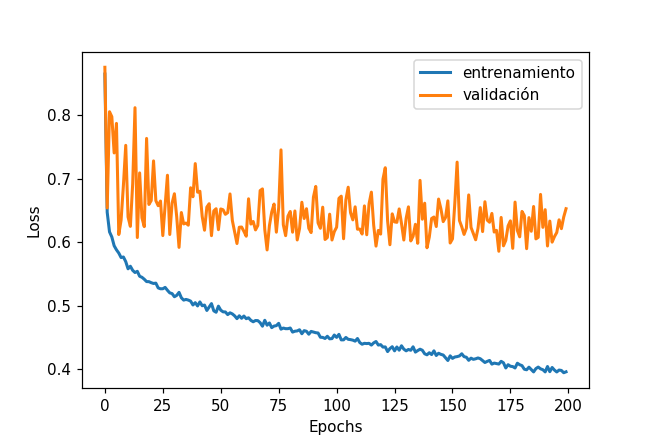

In [343]:
#plt.figure()
#plt.plot(range(len(TL)),TL,'r-',range(len(VL)),VL,'g-')
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(range(len(TL)), TL, lw=2, label='entrenamiento')
ax.plot(range(len(VL)), VL, lw=2, label='validación')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
#ax.set_ylim([0.2, 0.6])
plt.legend()
plt.show()

In [344]:
display(min(TL), min(VL))

0.3945270629631662

0.5858361651048516

In [321]:
#records = pd.DataFrame({'TrainLoss':[0.4471126899832771],'ValidLoss':[0.4270725921418016]}, dtype='float32')
def update_records(records,TL,VL,cambio):
    #global records
    new_result = pd.DataFrame({'TrainLoss':[min(TL)],'ValidLoss':[min(VL)],'Comment':cambio})
    records=records.append(new_result,ignore_index=True,sort=False)
    return records

In [347]:
records =update_records(records,TL,VL,comentario)
records.head()

,Comment,TrainLoss,ValidLoss
0,NaN,0.447113,0.427073
1,NaN,0.582066,0.372158
2,NaN,0.582907,0.454306
3,NaN,0.415818,0.621193
4,LR + 0.0002,0.406784,0.615324


Matriz de Confusion

- cargar mejor modelo
- un for que recorra elementos del dataset completo
    - tambien puede ser con el dataLoader pero SIN validacion
    - armar una lista con la cantidad de predichas
- preparar el dataset VVV
- pasarlo por modelo.forward(VVV['data'])
- softmax (?)
- guardar predicciones
- comparar con labels reales
- comparar 5 clases

In [345]:
besto = MLP()
#PATH = '/home/amorales/models/best_LC_model.pt'
besto.load_state_dict(torch.load(path)['model_state_dict'])

<All keys matched successfully>

In [346]:
# MODIFICAR
#y_true = [best_of_best[i]['label'].item() for i in range(len(best_of_best))]
#y_true = [VVV[i]['label'].item() for i in valid_idx]

#print(y_true)
prediction_test = []
labels_test=[]
for data in test_loader:
    inputs, labels = data['data'].unsqueeze(-1),data['label']
    labels_test.append(labels.detach().numpy())
    outputs = besto.forward(inputs,t=2)
    #logits = modelo.forward(sample_data)
    #print(outputs)
    prediction_test.append(outputs.detach().argmax(dim=1).numpy())
y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)
#print(y_pred)
cm = confusion_matrix(y_true, y_pred)
display(cm)

print(classification_report(y_true, y_pred))

array([[3194,  576,  681,    5,   15],
       [2748, 2951,  968,   25,   28],
       [  37,   18,  140,    1,    1],
       [   0,   16,    6, 5051,  208],
       [   0,    1,    0,   37,   69]])

              precision    recall  f1-score   support

           0       0.53      0.71      0.61      4471
           1       0.83      0.44      0.57      6720
           2       0.08      0.71      0.14       197
           3       0.99      0.96      0.97      5281
           4       0.21      0.64      0.32       107

    accuracy                           0.68     16776
   macro avg       0.53      0.69      0.52     16776
weighted avg       0.79      0.68      0.70     16776



In [ ]:
#y_true = [VVV[i]['label'].item() for i in test_set]
prediction_test = []
for data in test_loader:
    inputs, labels = data['data'],data['label']
    data,mask = inputs[:,:,:4],inputs[:,:,4].unsqueeze(-1)
    #print(data.shape,mask.shape)
    outputs=modelo.forward(data,mask,t=2)
    #logits = modelo.forward(sample_data)
    prediction_test.append(torch.argmax(outputs, dim=1).detach().numpy())

y_pred = np.concatenate(prediction_test)

cm = confusion_matrix(y_true, y_pred)
display(cm)

print(classification_report(y_true, y_pred))

In [ ]:
print("state_dict del módelo entrenado:")
for param_tensor in modelo.state_dict():
    print(param_tensor, "\t", modelo.state_dict()[param_tensor].size())
    print(param_tensor, "\t", modelo.state_dict()[param_tensor])

print("\nstate_dict del módelo recuperado:")
for param_tensor in besto.state_dict():
    print(param_tensor, "\t", besto.state_dict()[param_tensor].size())
    print(param_tensor, "\t", besto.state_dict()[param_tensor])

- ver la matriz de confusion de la red sin entrenar

In [ ]:
train_loader.sampler.num_samples

In [ ]:
test_loader.sampler.num_samples

In [ ]:
train_loader.dataset.__len__()

In [ ]:
test_loader.dataset.__len__()